## Access Wave Buoy Realtime NonQc data in Parquet

A jupyter notebook to show how to access and plot ARDC Wave data available as a [Parquet](https://parquet.apache.org) dataset on S3.

More information about the dataset available at [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/b299cdcd-3dee-48aa-abdd-e0fcdbb9cadc).

In [1]:
dataset_name = "wave_buoy_realtime_nonqc"

## Install/Update packages and Load common functions

In [2]:
# only run once, then restart session if needed
!pip install uv

import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the current directory of the notebook
current_dir = os.getcwd()

# Check if requirements.txt exists in the current directory
local_requirements = os.path.join(current_dir, 'requirements.txt')
if os.path.exists(local_requirements):
    requirements_path = local_requirements
else:
    # Fall back to the online requirements.txt file
    requirements_path = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt'

# Install packages using uv and the determined requirements file
if is_colab():
    os.system(f'uv pip install --system -r {requirements_path}')
else:
    os.system('uv venv')
    os.system(f'uv pip install -r {requirements_path}')

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 230 packages in 24ms


In [3]:
import requests
import os
if not os.path.exists('parquet_queries.py'):
  print('Downloading parquet_queries.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/ParquetDataQuery.py'
  response = requests.get(url)
  with open('parquet_queries.py', 'w') as f:
      f.write(response.text)

In [4]:
from parquet_queries import create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, get_spatial_extent, get_temporal_extent, get_schema_metadata
import pyarrow.parquet as pq
import pyarrow.dataset as pds
import pyarrow as pa
import os
import pandas as pd
import pyarrow.compute as pc

## Location of the parquet dataset

In [5]:
BUCKET_OPTIMISED_DEFAULT="aodn-cloud-optimised"
dname = f"s3://anonymous@{BUCKET_OPTIMISED_DEFAULT}/{dataset_name}.parquet/"
parquet_ds = pq.ParquetDataset(dname,partitioning='hive')

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [6]:
dataset = pds.dataset(dname, format="parquet", partitioning="hive")

partition_keys = dataset.partitioning.schema
print(partition_keys)

site_name: string
timestamp: int32
polygon: string


## List unique partition values

In [7]:
%%time
unique_partition_value = query_unique_value(parquet_ds, 'site_name')
print(list(unique_partition_value))

['Cape%20Naturaliste', 'Inverloch', 'Indented%20Head', 'Lakes%20Entrance', 'Cape%20Sorell', 'Esperance', 'Albany', 'Jurien', 'Sandringham', 'Apollo%20Bay', 'Central', 'Inverloch%20Inshore', 'Cape%20Bridgewater', 'Cape%20du%20Couedic', 'Cottesloe', 'Wilsons%20Prom', 'Port%20Fairy', 'Dutton%20Way', 'Rottnest%20Island', 'Mandurah', 'Rosebud', 'Mt%20Eliza', 'Werribee']
CPU times: user 13.8 ms, sys: 892 µs, total: 14.7 ms
Wall time: 13.4 ms


## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/parquet_queries.py:449: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/parquet_queries.py:449: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


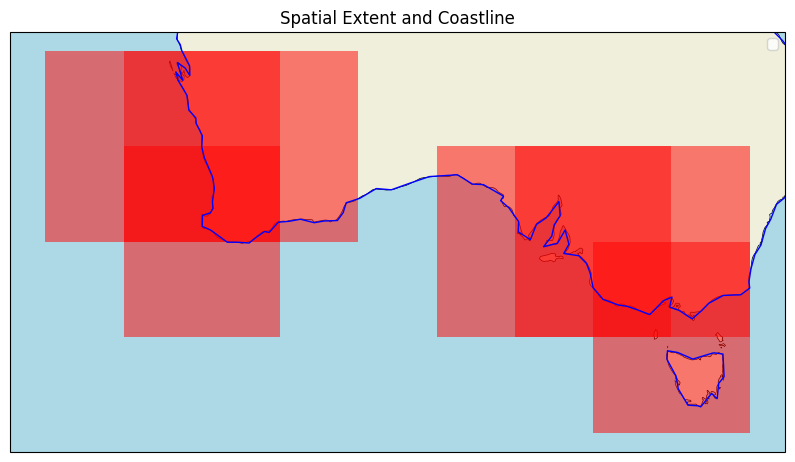

In [8]:
plot_spatial_extent(parquet_ds)

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [9]:
get_temporal_extent(parquet_ds)

(datetime.datetime(2022, 9, 1, 10, 0), datetime.datetime(2024, 7, 1, 10, 0))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [10]:
# parquet_meta = pa.parquet.read_schema(os.path.join(dname + '_common_metadata'))  # parquet metadata
metadata = get_schema_metadata(dname)  # schema metadata
metadata

{'timeSeries': {'type': 'int32',
  'long_name': 'unique identifier for each feature instance',
  'cf_role': 'timeseries_id'},
 'TIME': {'type': 'timestamp[ns]',
  'standard_name': 'time',
  'long_name': 'time',
  'axis': 'T',
  'valid_min': 0.0,
  'valid_max': 90000.0},
 'LATITUDE': {'type': 'double',
  'standard_name': 'latitude',
  'long_name': 'latitude',
  'units': 'degrees_north',
  'axis': 'Y',
  'valid_min': -90.0,
  'valid_max': 90.0,
  'reference_datum': 'WGS84 coordinate reference system; EPSG:4326'},
 'LONGITUDE': {'type': 'double',
  'standard_name': 'longitude',
  'long_name': 'longitude',
  'units': 'degrees_east',
  'axis': 'X',
  'valid_min': -180.0,
  'valid_max': 180.0,
  'reference_datum': 'WGS84 coordinate reference system; EPSG:4326'},
 'WHTH': {'type': 'double',
  'standard_name': 'sea_surface_wave_significant_height',
  'long_name': 'sea surface wave significant height from time domain analysis',
  'units': 'm',
  'valid_min': 0.0,
  'valid_max': 100.0,
  'method

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [11]:
filter_time = create_time_filter(parquet_ds, date_start='2022-12-01', date_end='2023-01-01')
filter_geo = create_bbox_filter(parquet_ds, lat_min=-40, lat_max=-20, lon_min=140, lon_max=160)


filter = filter_geo & filter_time

In [12]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   timeSeries            14835 non-null  int32         
 1   TIME                  14835 non-null  datetime64[ns]
 2   LATITUDE              14835 non-null  float64       
 3   LONGITUDE             14835 non-null  float64       
 4   WHTH                  0 non-null      float64       
 5   WPMH                  0 non-null      float64       
 6   WMXH                  0 non-null      float64       
 7   WPPE                  14835 non-null  float64       
 8   WPDI                  14835 non-null  float64       
 9   WPDS                  14835 non-null  float64       
 10  WAVE_quality_control  14835 non-null  float32       
 11  water_depth           14835 non-null  int64         
 12  wmo_id                0 non-null      object        
 13  filename        

## Create a TIME and scalar/number filter

In [13]:
filter_time = create_time_filter(parquet_ds, date_start='2020-07-12', date_end='2023-02-05')

expr_1 = pc.field('site_name') == pa.scalar("Cottesloe")
filter = expr_1 & filter_time

In [14]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   timeSeries            211 non-null    int32         
 1   TIME                  211 non-null    datetime64[ns]
 2   LATITUDE              211 non-null    float64       
 3   LONGITUDE             211 non-null    float64       
 4   WHTH                  211 non-null    float64       
 5   WPMH                  211 non-null    float64       
 6   WMXH                  211 non-null    float64       
 7   WPPE                  211 non-null    float64       
 8   WPDI                  211 non-null    float64       
 9   WPDS                  211 non-null    float64       
 10  WAVE_quality_control  211 non-null    float32       
 11  water_depth           211 non-null    int64         
 12  wmo_id                211 non-null    object        
 13  filename            

<Axes: xlabel='TIME', ylabel='sea_surface_wave_significant_height'>

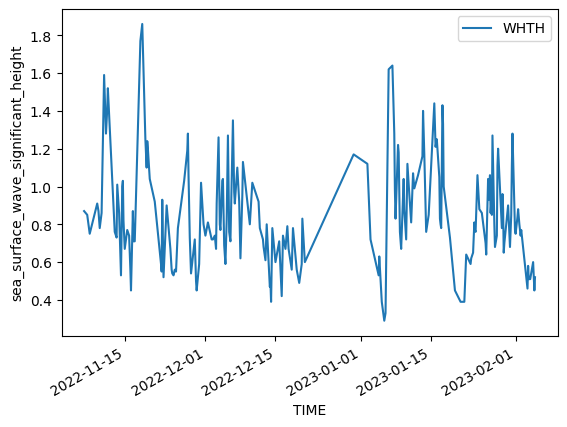

In [15]:
df[df['WAVE_quality_control'] == 2].sort_values('TIME').plot(x='TIME', 
                                                             y='WHTH', 
                                                             kind='line', 
                                                             ylabel=metadata['WHTH']['standard_name'])